数据增广
起因:由于不同实际场合之间有光影, 色温等差别, 一些视觉的数据在一个场合好用, 在另一个就场合效果不好
解决方案, 对我的数据进行多样化处理, 更多的噪音意味着更多样化的数据

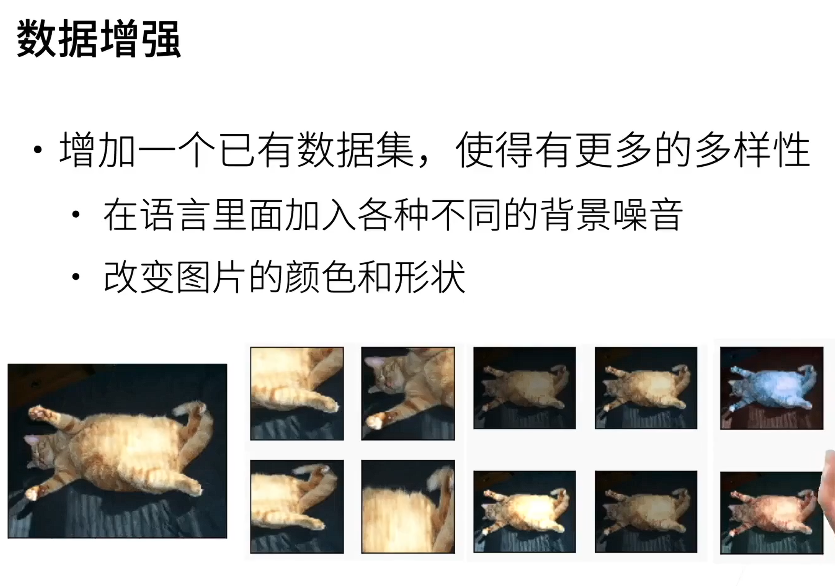

一般数据增强的方式:
- 上下翻转
- 切割
- 改变色调, 饱和度, 明亮度
- 还有别的办法

In [ ]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

d2l.set_figsize()
img = d2l.Image.open('../img/cat1.jpg')
d2l.plt.imshow(img);

一些增广的方法
见[课程代码](https://courses.d2l.ai/zh-v2/assets/notebooks/chapter_computer-vision/image-augmentation.slides.html#)

In [ ]:
def apply(img, aug, num_rows=2, num_cols=4, scale=1.5):
    Y = [aug(img) for _ in range(num_rows * num_cols)]
    d2l.show_images(Y, num_rows, num_cols, scale=scale)

In [ ]:
apply(img, torchvision.transforms.RandomHorizontalFlip())

In [ ]:
apply(img, torchvision.transforms.RandomVerticalFlip())

In [ ]:
shape_aug = torchvision.transforms.RandomResizedCrop(
    (200, 200), scale=(0.1, 1), ratio=(0.5, 2))
apply(img, shape_aug)

In [ ]:
apply(
    img,
    torchvision.transforms.ColorJitter(brightness=0.5, contrast=0,
                                       saturation=0, hue=0))

In [ ]:
color_aug = torchvision.transforms.ColorJitter(brightness=0.5, contrast=0.5,
                                               saturation=0.5, hue=0.5)
apply(img, color_aug)

In [ ]:
augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(), color_aug, shape_aug])
apply(img, augs)

In [ ]:
# 接下来, 使用增广进行训练
all_images = torchvision.datasets.CIFAR10(train=True, root="../data",
                                          download=True) # 加载CIFAR-10训练集
d2l.show_images([all_images[i][0] for i in range(32)], 4, 8, scale=0.8);

In [ ]:
# 训练集增强：随机水平翻转 + 转张量
train_augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor()]) # 转为4d张量, 便于训练

# 测试集增强：只做张量转换（不做随机增强）
test_augs = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()])

In [ ]:
# 定义一个辅助函数，以便于读取图像和应用图像增广
# 使用数据增广训练的核心在这里, 这里载入的augs是我们之前定义好的增强方式, 数据要经过这一步处理, 产生增强后的数据集, 再加入模型中
def load_cifar10(is_train, augs, batch_size):
    dataset = torchvision.datasets.CIFAR10(root="../data", train=is_train,
                                           transform=augs, download=True)
    dataloader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=is_train, # 根据is_train决定是否打乱数据
        num_workers=d2l.get_dataloader_workers()) # 使用多进程加载数据, 图片的增强对计算量要求高, 可能要多个worker
    return dataloader

In [ ]:
# 定义一个函数，使用多GPU对模型进行训练和评估
def train_batch_ch13(net, X, y, loss, trainer, devices):
    # 转移道GPU运算
    if isinstance(X, list):
        X = [x.to(devices[0]) for x in X]
    else:
        X = X.to(devices[0])
    y = y.to(devices[0])
    # 开始训练模式
    net.train()
    # 梯度清零
    trainer.zero_grad()
    # 正反向的传播和损失计算
    pred = net(X)
    l = loss(pred, y)
    l.sum().backward()
    # 更新参数
    trainer.step()
    # 计算loss和准确率
    train_loss_sum = l.sum()
    train_acc_sum = d2l.accuracy(pred, y)
    return train_loss_sum, train_acc_sum

def train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,
               devices=d2l.try_all_gpus()):
    timer, num_batches = d2l.Timer(), len(train_iter)
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1],
                            legend=['train loss', 'train acc', 'test acc'])
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(4)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = train_batch_ch13(net, features, labels, loss, trainer,
                                      devices)
            metric.add(l, acc, labels.shape[0], labels.numel())
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(
                    epoch + (i + 1) / num_batches,
                    (metric[0] / metric[2], metric[1] / metric[3], None))
        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {metric[0] / metric[2]:.3f}, train acc '
          f'{metric[1] / metric[3]:.3f}, test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec on '
          f'{str(devices)}')

In [ ]:
# 定义 train_with_data_aug 函数，使用图像增广来训练模型
batch_size, devices, net = 256, d2l.try_all_gpus(), d2l.resnet18(10, 3)

def init_weights(m):
    if type(m) in [nn.Linear, nn.Conv2d]:
        nn.init.xavier_uniform_(m.weight)

net.apply(init_weights)

def train_with_data_aug(train_augs, test_augs, net, lr=0.001):
    train_iter = load_cifar10(True, train_augs, batch_size)
    test_iter = load_cifar10(False, test_augs, batch_size)
    loss = nn.CrossEntropyLoss(reduction="none")
    trainer = torch.optim.Adam(net.parameters(), lr=lr)
    train_ch13(net, train_iter, test_iter, loss, trainer, 10, devices)

微调---省时省力的重要技术
起因: 收集和标注数据集的代价很大, 但是数据集越大越好, 如果我们总是能使用标好的数据集训练就好了

让我们从一般的神经网络开始说起:
一般的神经网络可以粗略地分为两类: 形态各异,复杂的特征提取网络, 和用于得出结果的线性回归

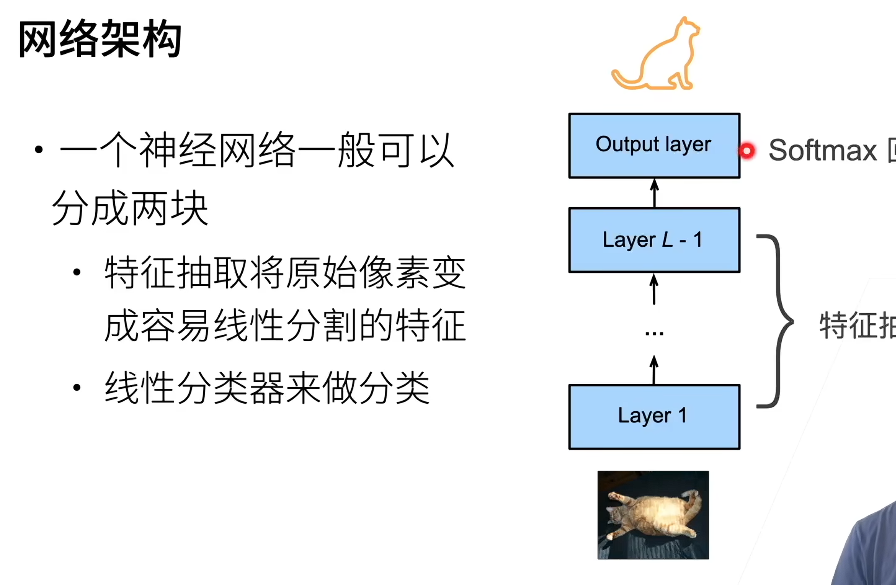

所以, 我们可以使用一些更好的数据集来做特征提取, 提取好之后, 我们的初始参数就会挺不错的
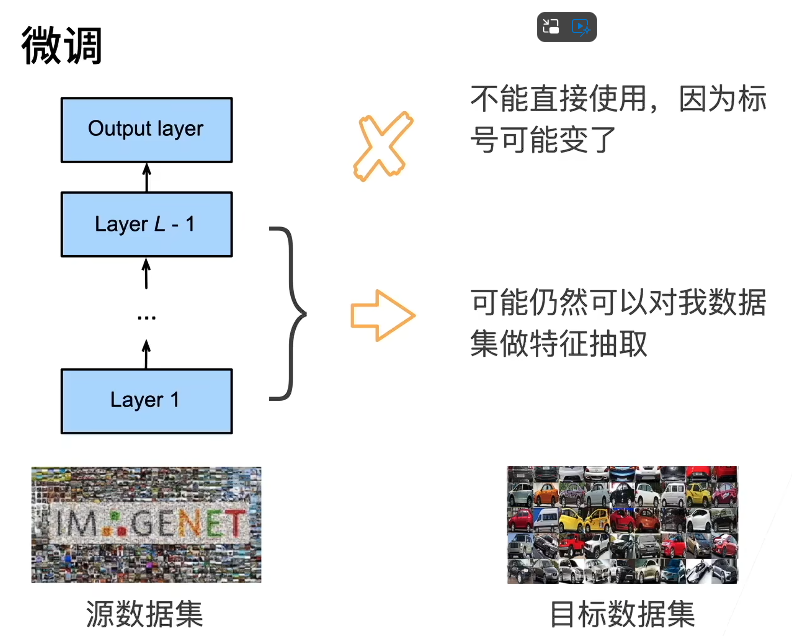

我们用别的模型训练的最终结果进行初始化, 然后我们在过一遍我们自己的模型, 这就是一种微调
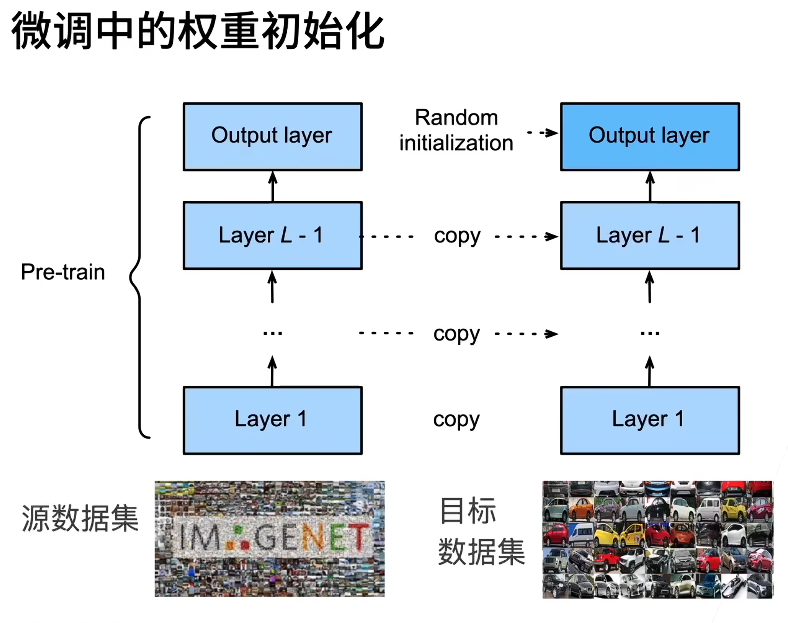

训练时, 我们通常使用更强的正则化: 更小的学习率, 更少的数据迭代, 来进行微调.
当源数据集远复杂于目标数据时, 微调的结果通常更好
训练时, 我们还可以固定底层的一些初始化参数, 让他们就是源数据集的结果, 因为底层的参数通常具有通用性, 有时候不改变效果会更好

In [ ]:
# 代码实现
%matplotlib inline
import os
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

In [ ]:
# 下载并加载数据集
d2l.DATA_HUB['hotdog'] = (d2l.DATA_URL + 'hotdog.zip',
                          'fba480ffa8aa7e0febbb511d181409f899b9baa5')

data_dir = d2l.download_extract('hotdog')

train_imgs = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'train'))
test_imgs = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'test'))

In [ ]:
hotdogs = [train_imgs[i][0] for i in range(8)]
not_hotdogs = [train_imgs[-i - 1][0] for i in range(8)]
d2l.show_images(hotdogs + not_hotdogs, 2, 8, scale=1.4);

In [ ]:
# 预训练模型（如ResNet）是在标准化后的ImageNet数据上训练的，输入必须保持相同的分布
normalize = torchvision.transforms.Normalize([0.485, 0.456, 0.406],
                                             [0.229, 0.224, 0.225])
# mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]）是ImageNet数据集上统计得到的全局平均值
# 由于ResNet等模型是在ImageNet上预训练的，输入数据必须采用相同的标准化参数才能保证特征提取的有效性

# 图像增强
train_augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(224),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(), normalize])

test_augs = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(), normalize])

In [ ]:
# 加载预训练模型 resnet18(pretrained=True)
pretrained_net = torchvision.models.resnet18(pretrained=True)

pretrained_net.fc

In [ ]:
# 修改最后一层（全连接层）​
finetune_net = torchvision.models.resnet18(pretrained=True)
finetune_net.fc = nn.Linear(finetune_net.fc.in_features, 2) # 输出2类（热狗/非热狗）
nn.init.xavier_uniform_(finetune_net.fc.weight);  # Xavier初始化最后一层, 因为最后一层无法迁移, 所以随机初始化即可

In [ ]:
# 微调训练
def train_fine_tuning(net, learning_rate, batch_size=128, num_epochs=5,
                      param_group=True):
    train_iter = torch.utils.data.DataLoader(
        torchvision.datasets.ImageFolder(os.path.join(data_dir, 'train'),
                                         transform=train_augs),
        batch_size=batch_size, shuffle=True) # 训练集, 批量大小, 打乱
    test_iter = torch.utils.data.DataLoader(
        torchvision.datasets.ImageFolder(os.path.join(data_dir, 'test'),
                                         transform=test_augs),
        batch_size=batch_size)
    devices = d2l.try_all_gpus()
    loss = nn.CrossEntropyLoss(reduction="none")
    # 策略 1：param_group=True（分层学习率）​​
    # ​核心思想​：
    # ​预训练层（卷积层等）​​：使用较小的学习率（learning_rate），​微调现有特征，避免破坏预训练权重。
    # ​新层（全连接层 fc）​​：使用较大的学习率（learning_rate * 10），​快速学习新任务的特征。
    if param_group:
        params_1x = [
            param for name, param in net.named_parameters()
            if name not in ["fc.weight", "fc.bias"]]
        trainer = torch.optim.SGD([{
            'params': params_1x}, {
                'params': net.fc.parameters(),
                'lr': learning_rate * 10}], lr=learning_rate,
                                  weight_decay=0.001)
    # 策略 2：param_group=False（统一学习率）​​
    # 核心思想​：
    # 所有参数​（包括预训练层和新层）使用相同的学习率（learning_rate）。
    else:
        trainer = torch.optim.SGD(net.parameters(), lr=learning_rate,
                                  weight_decay=0.001)
    d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,
                   devices)

In [ ]:
train_fine_tuning(finetune_net, 5e-5)